In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')
rc('axes', axisbelow=True)

### Problem 2(a)

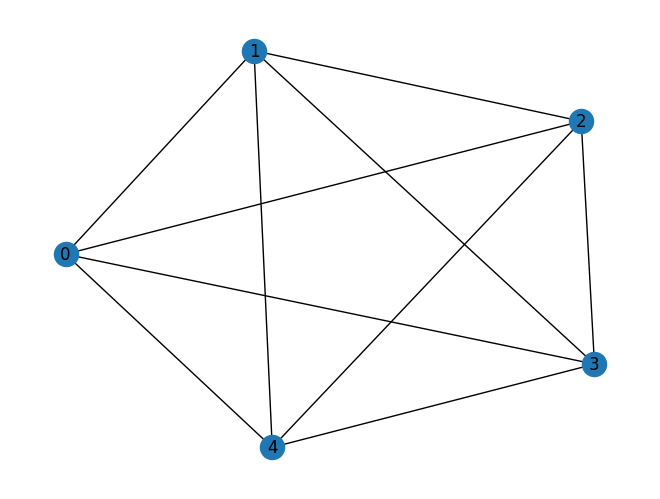

In [6]:
n = 5
G = nx.complete_graph(n)

nx.draw(G, with_labels = True)

plt.savefig('/Users/lpwer/Documents/NetSIPhD/PHYS7332_NetData/HW1/problem2a.png', bbox_inches='tight')

### Problem 2b

In [4]:
def degree_preserving_randomization(G, n_iter = 500, fail_max = 200):
    """
    Perform degree-preserving randomization on a graph. 

    This function is modified based on Algorithm 11.1 in Bagrow & Ahn textbook. This version of randomization prevent an infinite loop
    by abandoning the exvhange process after reaching a given number of attempts without a successful exchange. 
    
    Parameters
    ----------
    G : networkx.Graph
        the input graph to be randomized. The graph can be directed or undirected. Must be simple. 

    n_iter : int, optional (default = 1000)
        the number of edge exchange to perform. A higher number of iteration leads to more randomization. 
        In this case, we preserve the degree of nodes. This number should be proportional to the number of edges in the graph
        for sufficient randomization. 

    fail_max : int 
        fail_max is a counter cap that makes sure the exchange process will stop if the infinite loop happens. 

    Returns
    -------
    G_random : networkx.Graph
        A randomized graph with same degree distirbution as the input graph G but with a shuffled edge structure. 

    Notes
    -----
    - This function works by randomly select two independent edges in the network (u, v) and (x, y).
      The attempted exchanges are {(u, x), (v, y)} and {(u, y), (x, v)}.
    - swapped is a flag that checks on whether the edge exchange is successful or not. 
      If swapped is true, then add 1 to the success counter and reset the n_fail counter. 
    - When number of failure reaches the max failure, raise the runtime error and stop the function. 

    Example
    -------
    >>> import networkx as nx
    >>> G = nx.erdos_renyi_graph(10, 0.5)
    >>> G_random = degree_preserving_randomization(G, n_iter=100)

    Citations
    ---------
    Klein, Brennan. PHYS 7332 Fall 2025 Class04 notes
    """
    G_random = G.copy()
    edges = list(G_random.edges())
    num_edge = len(edges)
    n_fail = 0
    success = 0 

    swapped = False

    while n_fail < fail_max and success < n_iter:
        edge1_id = np.random.choice(list(range(num_edge)))
        u, v = edges[edge1_id]
        edge2_id = np.random.choice(list(range(num_edge)))
        x, y = edges[edge2_id]
        
        if len({u, v, x, y}) == 4 and n_fail < fail_max:
            if np.random.rand() > 0.5:
                if not (G_random.has_edge(u, x) or G_random.has_edge(v, y)):
                    G_random.remove_edge(u,v)
                    G_random.remove_edge(x,y)
                    G_random.add_edge(u,x)
                    G_random.add_edge(v,y)
                    swapped = True
                        
            else:
                if not (G_random.has_edge(u, y) or G_random.has_edge(v, x)):
                    G_random.remove_edge(u,v)
                    G_random.remove_edge(x,y)
                    G_random.add_edge(u,y)
                    G_random.add_edge(v,x)
                    swapped = True
        if swapped:
            success += 1
            n_fail = 0
            edges = list(G_random.edges())
        else:
            n_fail += 1

    if n_fail >= fail_max:
        raise RuntimeError(f"Stopped: reached {fail_max} consecutive failed attempts. "
                       "No further swaps possible.")
            
    return G_random

Text(0.5, 1.0, 'Randomized graph')

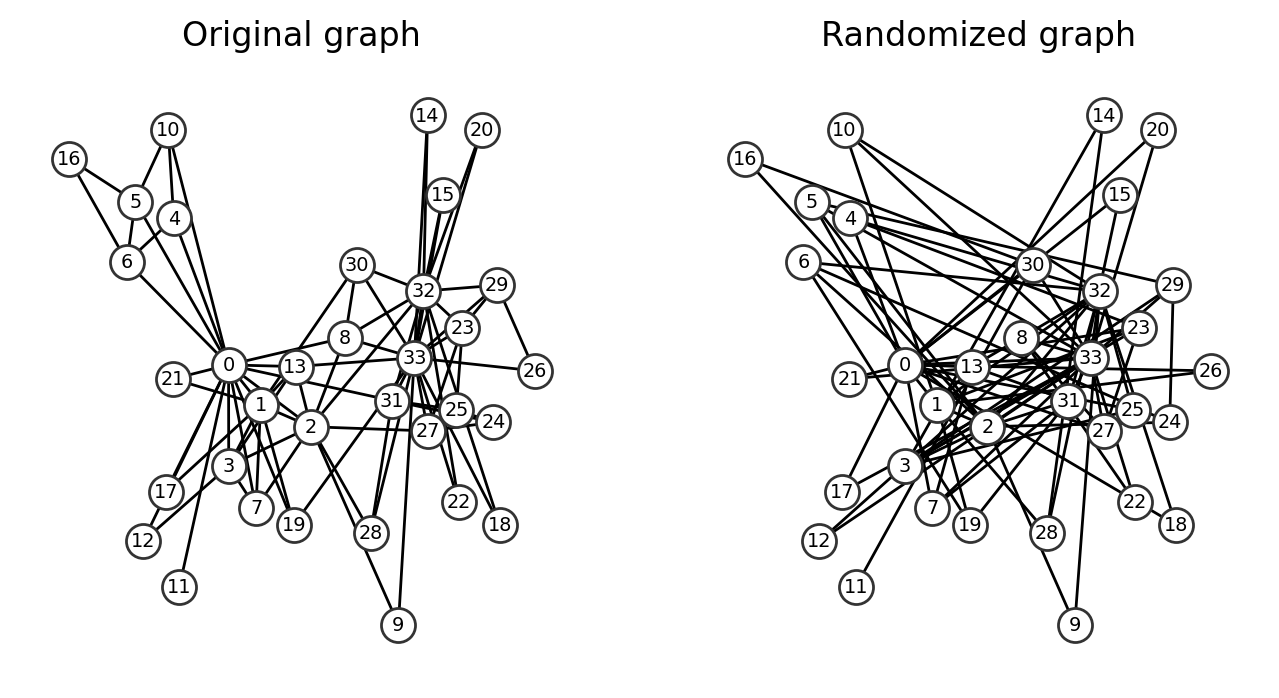

In [6]:
G = nx.karate_club_graph()
# G = nx.complete_graph(30)
G_random = degree_preserving_randomization(G)
# plot
pos = nx.spring_layout(G)
fig, ax = plt.subplots(1, 2, figsize=(8,4), dpi=200)

nx.draw(G, pos, node_size = 150, node_color='w', edgecolors='.2',
        with_labels=True, font_size='x-small', ax = ax[0])
ax[0].set_title('Original graph')

nx.draw(G_random, pos, node_size = 150, node_color='w', edgecolors='.2',
        with_labels=True, font_size='x-small', ax = ax[1])
ax[1].set_title('Randomized graph')


### Problem 3


In [9]:
from collections import deque

def all_shortest_from(G, s):
    """
    Unweighted BFS from source s.
    Returns:
      dist[v]  : shortest-path distance from s to v (=-1 if unreachable)
      g[v]     : number of shortest paths from s to v
      P[v]     : list of predecessors of v on shortest s->v paths
    """
    dist  = {v: -1 for v in G.nodes()}
    g = {v:  0 for v in G.nodes()}
    P = {v: [] for v in G.nodes()}

    dist[s] = 0
    g[s] = 1

    Q = deque([s])
    while Q:
        v = Q.popleft()
        for w in G.neighbors(v):
            if dist[w] < 0:
                dist[w] = dist[v] + 1
                Q.append(w)
            if dist[w] == dist[v] + 1:
                g[w] += g[v]
                P[w].append(v)
    return dist, g, P


def indicator_betweenness_unscaled(G, endpoints=False):
    """
    Indicator betweenness (UNWEIGHTED, UNSCALED):
      For each ordered pair (s, t), s!=t, every node i on at least one
      shortest s->t path gets + 1 / g_st (once per pair).

    endpoints=False: do NOT credit s or t.
    endpoints=True : DO credit s and t as well.
    """
    bc = {v: 0.0 for v in G.nodes()}
    nodes = list(G.nodes())

    for s in nodes:
        dist, g, P = all_shortest_from(G, s)

        # Consider only reachable targets t != s with g[t] > 0
        targets = [t for t in nodes if t != s and g[t] > 0]

        for t in targets:
            contrib = 1.0 / g[t]

            # Reverse-walk the predecessor DAG from t to mark
            # all nodes on at least one shortest s->t path.
            stack = [t]
            visited = {t}
            while stack:
                w = stack.pop()

                # Credit rule: indicator version (once per (s,t) if w lies on any shortest path)
                if endpoints:
                    bc[w] += contrib
                else:
                    if w != s and w != t:
                        bc[w] += contrib

                for v in P[w]:
                    if v not in visited:
                        visited.add(v)
                        stack.append(v)

    return bc


{0: 253.5095815295816, 1: 41.78571428571429, 2: 137.45878787878775, 3: 26.584761904761905, 4: 19.06109668109667, 5: 23.29904761904762, 6: 15.965714285714274, 7: 0.0, 8: 32.612756132756104, 9: 1.277056277056277, 10: 0.0, 11: 0.0, 12: 0.0, 13: 36.2905339105339, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 25.004819624819593, 20: 0.0, 21: 0.0, 22: 0.0, 23: 13.8, 24: 2.333333333333333, 25: 3.5309379509379513, 26: 0.0, 27: 22.707994227994217, 28: 2.277056277056277, 29: 3.2675324675324675, 30: 10.219047619047615, 31: 101.34608946608958, 32: 115.369898989899, 33: 216.38735930735936}


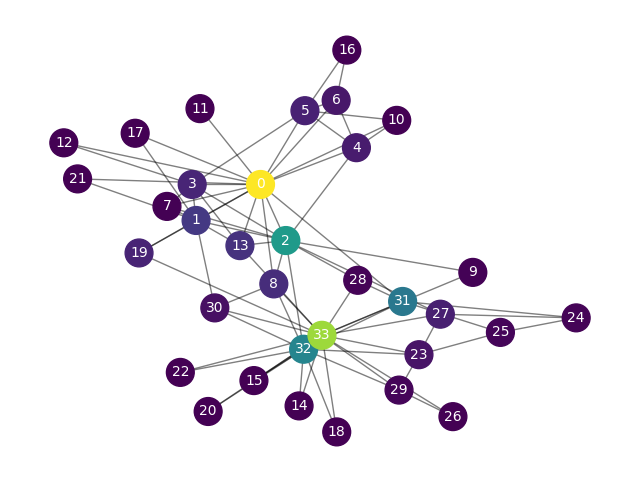

In [12]:
G = nx.karate_club_graph()
G.add_edges_from([(1,2),(2,3),(2,4),(3,5),(4,5)])

bc_ind = indicator_betweenness_unscaled(G, endpoints=False)
print(bc_ind)
node_values = [bc_ind[v] for v in G.nodes()]

# Draw
pos = nx.spring_layout(G, seed=42)  # layout for positioning

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(
    G, pos,
    node_color=node_values,
    cmap=plt.cm.viridis,   # choose any matplotlib colormap
    node_size=400
)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="white")
plt.axis("off")
plt.show()

### Problem 4a

In [63]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

In [73]:
catalog_res = requests.get('https://catalog.northeastern.edu/course-descriptions/phth/')
catalog_html = catalog_res.text

soup = BeautifulSoup(catalog_html)

In [85]:
COURSE_CODE_RE = re.compile(r'\b[A-Z&]{2,}\s?\d{4}\b')

def norm(s: str | None) -> str | None:
    """Normalize whitespace and non-breaking spaces."""
    if s is None:
        return None
    return " ".join(s.replace("\xa0", " ").split())

def extract_prereq_codes(prereq_p) -> list[str]:
    """
    Given the <p> tag that contains prerequisites, return a list of course codes.
    Works for both <a> links and plain text course codes.
    """
    if prereq_p is None:
        return []

    found = []
    seen = set()

    # 1) linked prereqs
    for a in prereq_p.find_all('a'):
        code = norm(a.get_text(strip=True))
        if code and COURSE_CODE_RE.fullmatch(code) and code not in seen:
            seen.add(code)
            found.append(code)

    # 2) unlinked prereqs from the raw text
    text = norm(prereq_p.get_text(" "))
    if text:
        for code in COURSE_CODE_RE.findall(text):
            code = norm(code)
            if code not in seen:
                seen.add(code)
                found.append(code)

    return found

def parse_courses(soup) -> list[dict]:
    """
    Parse all course blocks from the HTML soup and return a list of dicts.
    Each dict includes: course_crn, course_title, credits, description, prerequisites (list of strings).
    """
    course_info = []

    for class_i in soup.find_all('div', {'class': 'courseblock'}):
        # course header
        title_p = class_i.find('p', {'class': 'courseblocktitle noindent'})
        if not title_p:
            continue
        class_title_total_i = norm(title_p.get_text())
        try:
            crn_i, title_i, credit_i = class_title_total_i.split('. ', 2)
        except ValueError:
            # sometimes format may differ
            continue

        # description
        desc_p = class_i.find('p', class_='cb_desc')
        desc_i = norm(desc_p.get_text()) if desc_p else None

        # find prereq <p>
        prereq_p = None
        for p in class_i.find_all('p', class_='courseblockextra noindent'):
            strong = p.find('strong')
            head = norm(strong.get_text()) if strong else ''
            if head and head.lower().startswith('prerequisite'):
                prereq_p = p
                break

        prereqs = extract_prereq_codes(prereq_p)

        course_info.append({
            "course_crn": crn_i,
            "course_title": title_i,
            "credits": credit_i,
            "description": desc_i,
            "prerequisite": prereqs
        })

    return pd.DataFrame(course_info)


In [89]:
catalog_html = catalog_res.text
soup = BeautifulSoup(catalog_html)

courses = parse_courses(soup)
print(courses.head()[["course_title", "description"]])  

                                      course_title  \
0                   The American Healthcare System   
1                   Comparative Healthcare Systems   
2                    Introduction to Global Health   
3                     Foundations of Biostatistics   
4  Communication Skills for the Health Professions   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

### Problem 4b

In [87]:
import networkx as nx
G = nx.DiGraph()

In [105]:
def curriculum_graph(df):
    for row in courses.itertuples():
        G.add_node(
            row.course_crn,
            title = row.course_title,
            credits = row.credits,
            desc = row.description
        )
    
    for row in courses.itertuples():
        for prereq in row.prerequisite:
            if prereq not in G:
                G.add_node(prereq)
            G.add_edge(prereq, row.course_crn)
    
    return G

def draw_curriculum_graph(G):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    
    nx.draw(
        G,
        pos,
        with_labels=True,
        labels={node: node for node in G.nodes()},
        node_size=1000,
        node_color="lightblue",
        edge_color="gray",
        font_size=8,
        arrows=True,
        arrowstyle="-|>",
        arrowsize=12
    )

    plt.title("Curriculum Prerequisite Graph", fontsize=14)
    plt.show()

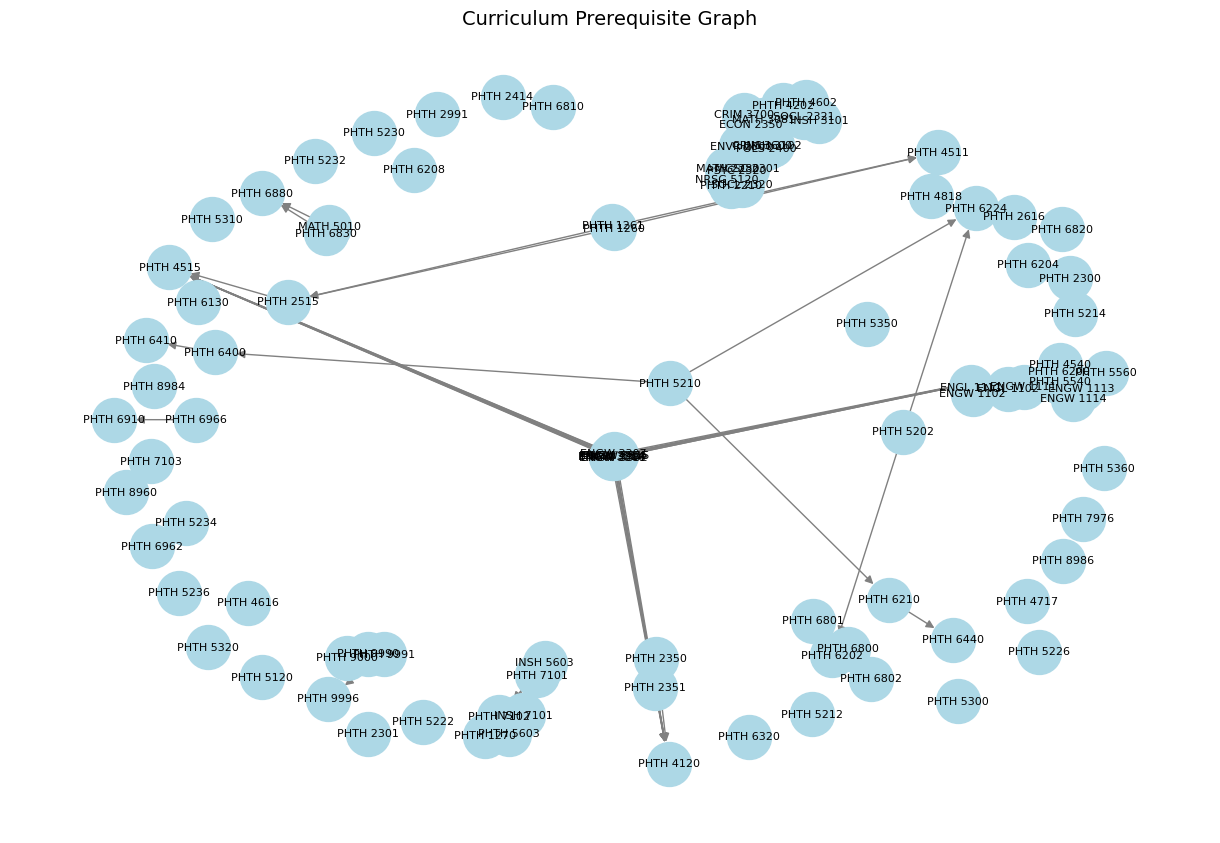

In [106]:
G = curriculum_graph(courses)

draw_curriculum_graph(G)